<a href="https://colab.research.google.com/github/AndrewCrossman/Graduate_Research/blob/main/Find_Structure_Energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
import math
import numpy as np
from astropy.coordinates import cartesian_to_spherical
import pandas as pd
import scipy as sp
from sklearn.neighbors import KDTree
from scipy import optimize
from google.colab import files
import requests
from bs4 import BeautifulSoup
import json
from collections import Counter
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Energy from Interaction Volume

In [2]:
# File names to determine energy from
files = ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/refs/heads/main/Control/STRs/Sphere100_Au_onAu_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/25_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/50_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/75_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/100_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/125_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/150_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/175_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/200_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/225_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/250_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/275_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/300_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/325_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/350_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/375_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/400_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/425_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/450_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/475_voidless.stru",
         "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Sized_Au_Spheres/MC_Sphere100_Au_onAu_r25/500_voidless.stru"]


In [25]:
def determine_structure_energy(file, interaction_radius):
  '''
  INPUT:    (string) *.stru filename, (float) interaction radius in units of unit cell
  OUTPUT:   (float) total energy of structure, (float) total energy of structure per atom
  Reads in a *.stru file and returns the total energy of the structure and total energy of the structure per atom as floats
  '''
  #############################################################################
  # Format Data in pandas dataframe
  #############################################################################
  data = pd.read_csv(file, skiprows=4, sep="\s+")
  data = data.drop(data.columns[4:], axis=1)
  data = data.replace(',','', regex=True)
  data = data.set_axis(["atom", "x", "y", "z"], axis=1)
  data = data[data.atom!='VOID']        # Removes all voids
  data["x"] = data["x"].astype(float)
  data["y"] = data["y"].astype(float)
  data["z"] = data["z"].astype(float)
  data = data.drop(data.columns[0], axis=1)
  print(data.head())
  data_ar = data.to_numpy()
  # Read structural data into a KDTree
  tree = KDTree(data_ar, leaf_size=2)
  all_nn_indices = tree.query_radius(data_ar, r=interaction_radius)
  #############################################################################
  # Calculate LJ Energy of the structure
  #############################################################################
  # values taken from Heinz 2008 (Accurate Simulation of Surfaces and Interfaces ...)
  atom_energies = []
  atom_distances = []
  dists = []
  Energy = 0
  E = 5.29 * 0.04335667   # convert from kcal per mole to eV per atom
  r0 = 2.951              # angstroms
  A = E*r0**12            # E*r0^12 in (eV * angstrom^11)
  B = 2*E*r0**6           # 2*E*r0^6 in (kcal * angstrom^5)
  lp = 4.078900           # lattice parameter

  for i in range(len(data_ar)):         # cycle through all atoms with index i
    E_n = 0
    for n in all_nn_indices[i]:         # for each atom i, determine LJ energy about nieghbors determined through KDTree
      if n!=i:
        dist = np.linalg.norm(data_ar[n]-data_ar[i])  # finds the distance between the atom at index i and index n in units of unit cell
        dist = dist*lp
        if dist>2:
          d3 = dist*dist*dist
          d6 = d3*d3
          d12= d6*d6
          sum = A/d12 - B/d6
          dists.append(dist)
          E_n = E_n + sum
    atom_energies.append(E_n)
    atom_distances.append(np.linalg.norm(data_ar[i])*lp)
  atom_energies = [x*0.5 for x in atom_energies]          # half energies to account for doublr counting
  Energy = np.sum(atom_energies)
  num_of_atoms = len(data.index)
  e_per_atom = Energy/num_of_atoms # lattice energy per atom in eV
  plt.hist(dists)                  # plots the distances
  return(Energy, e_per_atom)

     x    y    z
0  0.0 -2.5 -5.5
1  1.0 -2.5 -5.5
2 -2.0 -1.5 -5.5
3 -1.5 -2.0 -5.5
4 -1.0 -1.5 -5.5
          x         y         z
0 -1.013394 -2.486474 -5.576060
1 -0.000137 -2.511968 -5.594550
2  1.035076 -2.524354 -5.604323
3 -2.090142 -1.551562 -5.566894
4 -1.581993 -2.045397 -5.559450
          x         y         z
0 -1.032878 -2.511418 -5.630379
1  0.002173 -2.512775 -5.604732
2  0.986802 -2.547721 -5.589163
3 -2.017086 -1.550688 -5.625261
4 -1.503156 -1.996137 -5.617225
          x         y         z
0 -1.004671 -2.514455 -5.617671
1 -0.012344 -2.521178 -5.578191
2  1.038844 -2.537170 -5.574178
3 -2.027576 -1.476581 -5.588127
4 -1.500957 -2.011314 -5.638896
          x         y         z
0 -1.046163 -2.538436 -5.579585
1 -0.039142 -2.534500 -5.582922
2  0.981332 -2.542272 -5.551740
3 -2.076412 -1.541052 -5.600168
4 -1.533073 -1.984207 -5.571723
          x         y         z
0 -1.076798 -2.527129 -5.593821
1  0.002328 -2.514470 -5.616553
2  0.963842 -2.601489 -5.614978
3 

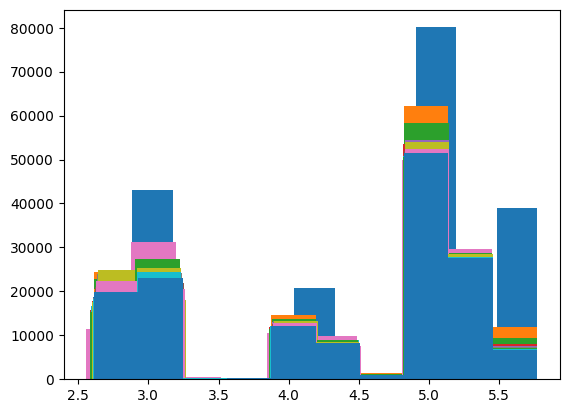

In [26]:
total_structure_energy = []
total_structure_energy_per_atom = []
  # np.sqrt(2)*1 corresponds to the fourth NN distance in FCC lattice
  # instead of writing the lattice parameter, we use 1 because the structure
  # file that is used as input measures the distances in lattice parameters
radius = np.sqrt(2)*1

for file in files:
  Energy, e_per_atom = determine_structure_energy(file, radius)
  total_structure_energy.append(Energy)
  total_structure_energy_per_atom.append(e_per_atom)

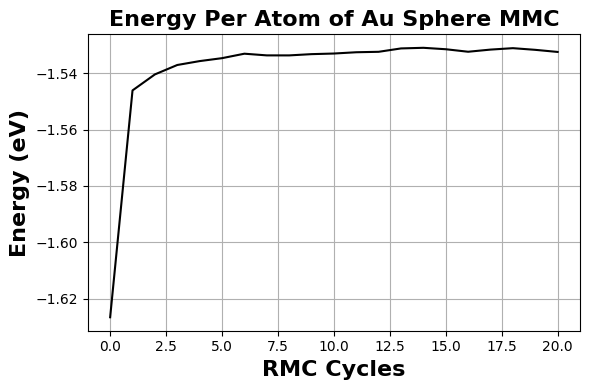

In [28]:
fig, ax = plt.subplots(figsize=(6,4))
#ax.scatter(np.arange(25,525,25),total_structure_energy_per_atom, color='black')
ax.plot(total_structure_energy_per_atom, color='black')
ax.set_title(r'Energy Per Atom of Au Sphere MMC', fontsize=16, fontweight='bold')
ax.set_xlabel(r'RMC Cycles', fontsize=16, fontweight='bold')
ax.set_ylabel(r'Energy (eV)', fontsize=16, fontweight='bold')
ax.grid()
plt.tight_layout()

## Find all structure files and/or BLD files for MMC or RMC Process

### Automatically find all of the Stucture Files or BLDs from Github directory - currently not working :(

In [ ]:
# the URL of the target repo to scrape
url = 'https://github.com/AndrewCrossman/Graduate_Research/tree/main/Tests/MC_Coreshell5050_AuPd_onAu_r50'
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')


[]

### Manually record all of the Structure Files or BLDs

In [ ]:
Stru_filenames = [
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Control/Control/STRs/Coreshell5050_AuPd_onAu_r50_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/500_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/1000_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/1500_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/2000_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/2500_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/3000_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/3500_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/4000_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/4500_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/5000_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/5500_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/6000_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/6500_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/7000_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/7500_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/8000_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/8500_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/9000_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/9500_voidless.stru",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/10000_voidless.stru"
]

bld_filenames = [
    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Control/Control/BLDs/Coreshell5050_AuPd_onAu_r50_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Control/Control/BLDs/Coreshell5050_AuPd_onAu_r50_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Control/Control/BLDs/Coreshell5050_AuPd_onAu_r50_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/500_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/500_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/500_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/1000_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/1000_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/1000_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/1500_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/1500_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/1500_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/2000_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/2000_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/2000_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/2500_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/2500_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/2500_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/3000_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/3000_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/3000_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/3500_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/3500_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/3500_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/4000_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/4000_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/4000_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/4500_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/4500_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/4500_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/5000_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/5000_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/5000_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/5500_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/5500_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/5500_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/6000_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/6000_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/6000_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/6500_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/6500_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/6500_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/7000_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/7000_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/7000_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/7500_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/7500_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/7500_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/8000_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/8000_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/8000_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/8500_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/8500_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/8500_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/9000_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/9000_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/9000_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/9500_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/9500_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/9500_PdPd.bld"],

    ["https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/10000_AuAu.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/10000_AuPd.bld",
    "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuPd_onAu_r50/10000_PdPd.bld"]
]


## Solve for Lattice Energy Using BLDs

### Set Parameters for LJ Potential

In [ ]:
################################################################################
# Manually Set Vaiables
################################################################################
N = 30885      # number of atoms in structure
KcalPerMole_to_eVPerAtom = (2.611*10**22)/(6.0221408*10**23)  # kcal/mole converted to eV/atom
E_AuAu = 5.29 * KcalPerMole_to_eVPerAtom  # eV
E_AuPd = 5.72 * KcalPerMole_to_eVPerAtom  # eV
E_PdPd = 6.15 * KcalPerMole_to_eVPerAtom  # eV
r0_AuAu = 2.951   # angstroms
r0_AuPd = 2.885   # angstroms
r0_PdPd = 2.819   # angstroms
################################################################################
# Varaibles Assigned from Manually Set ones to make computation faster
################################################################################
A_AuAu = E_AuAu*(r0_AuAu**12)    # E*r0^12 in (kcal * angstrom^12) per mole
B_AuAu = 2*E_AuAu*(r0_AuAu**6)   # 2*E*r0^6 in (kcal * angstrom^6) per mole

A_AuPd = E_AuPd*(r0_AuPd**12)    # E*r0^12 in (kcal * angstrom^12) per mole
B_AuPd = 2*E_AuPd*(r0_AuPd**6)   # 2*E*r0^6 in (kcal * angstrom^6) per mole

A_PdPd = E_PdPd*(r0_PdPd**12)    # E*r0^12 in (kcal * angstrom^12) per mole
B_PdPd = 2*E_PdPd*(r0_PdPd**6)   # 2*E*r0^6 in (kcal * angstrom^6) per mole

In [ ]:
total_energy_per_cycle = []
for files in bld_filenames:
  data1 = pd.read_csv(files[0],header=None,delimiter=' ')[[2,4]].rename(columns={2: 'r', 4: 'pairs'})
  data2 = pd.read_csv(files[1],header=None,delimiter=' ')[[2,4]].rename(columns={2: 'r', 4: 'pairs'})
  data3 = pd.read_csv(files[2],header=None,delimiter=' ')[[2,4]].rename(columns={2: 'r', 4: 'pairs'})

  data1['d6'] = data1['r']*data1['r']*data1['r']*data1['r']*data1['r']*data1['r']
  data1['d12'] = data1['d6']*data1['d6']
  data1['Energy'] = (A_AuAu/data1['d12'] - B_AuAu/data1['d6']) * data1['pairs']/2   #Divide by 2 to account for double counting of pairs

  data2['d6'] = data2['r']*data2['r']*data2['r']*data2['r']*data2['r']*data2['r']
  data2['d12'] = data2['d6']*data2['d6']
  data2['Energy'] = (A_AuPd/data2['d12'] - B_AuPd/data2['d6']) * data2['pairs']/2   #Divide by 2 to account for double counting of pairs

  data3['d6'] = data3['r']*data3['r']*data3['r']*data3['r']*data3['r']*data3['r']
  data3['d12'] = data3['d6']*data3['d6']
  data3['Energy'] = (A_PdPd/data3['d12'] - B_PdPd/data3['d6']) * data3['pairs']/2   #Divide by 2 to account for double counting of pairs

  total_energy_per_cycle.append(data1['Energy'].sum() +data2['Energy'].sum() + data3['Energy'].sum())

total_energy_per_cycle =  [i/N for i in total_energy_per_cycle]

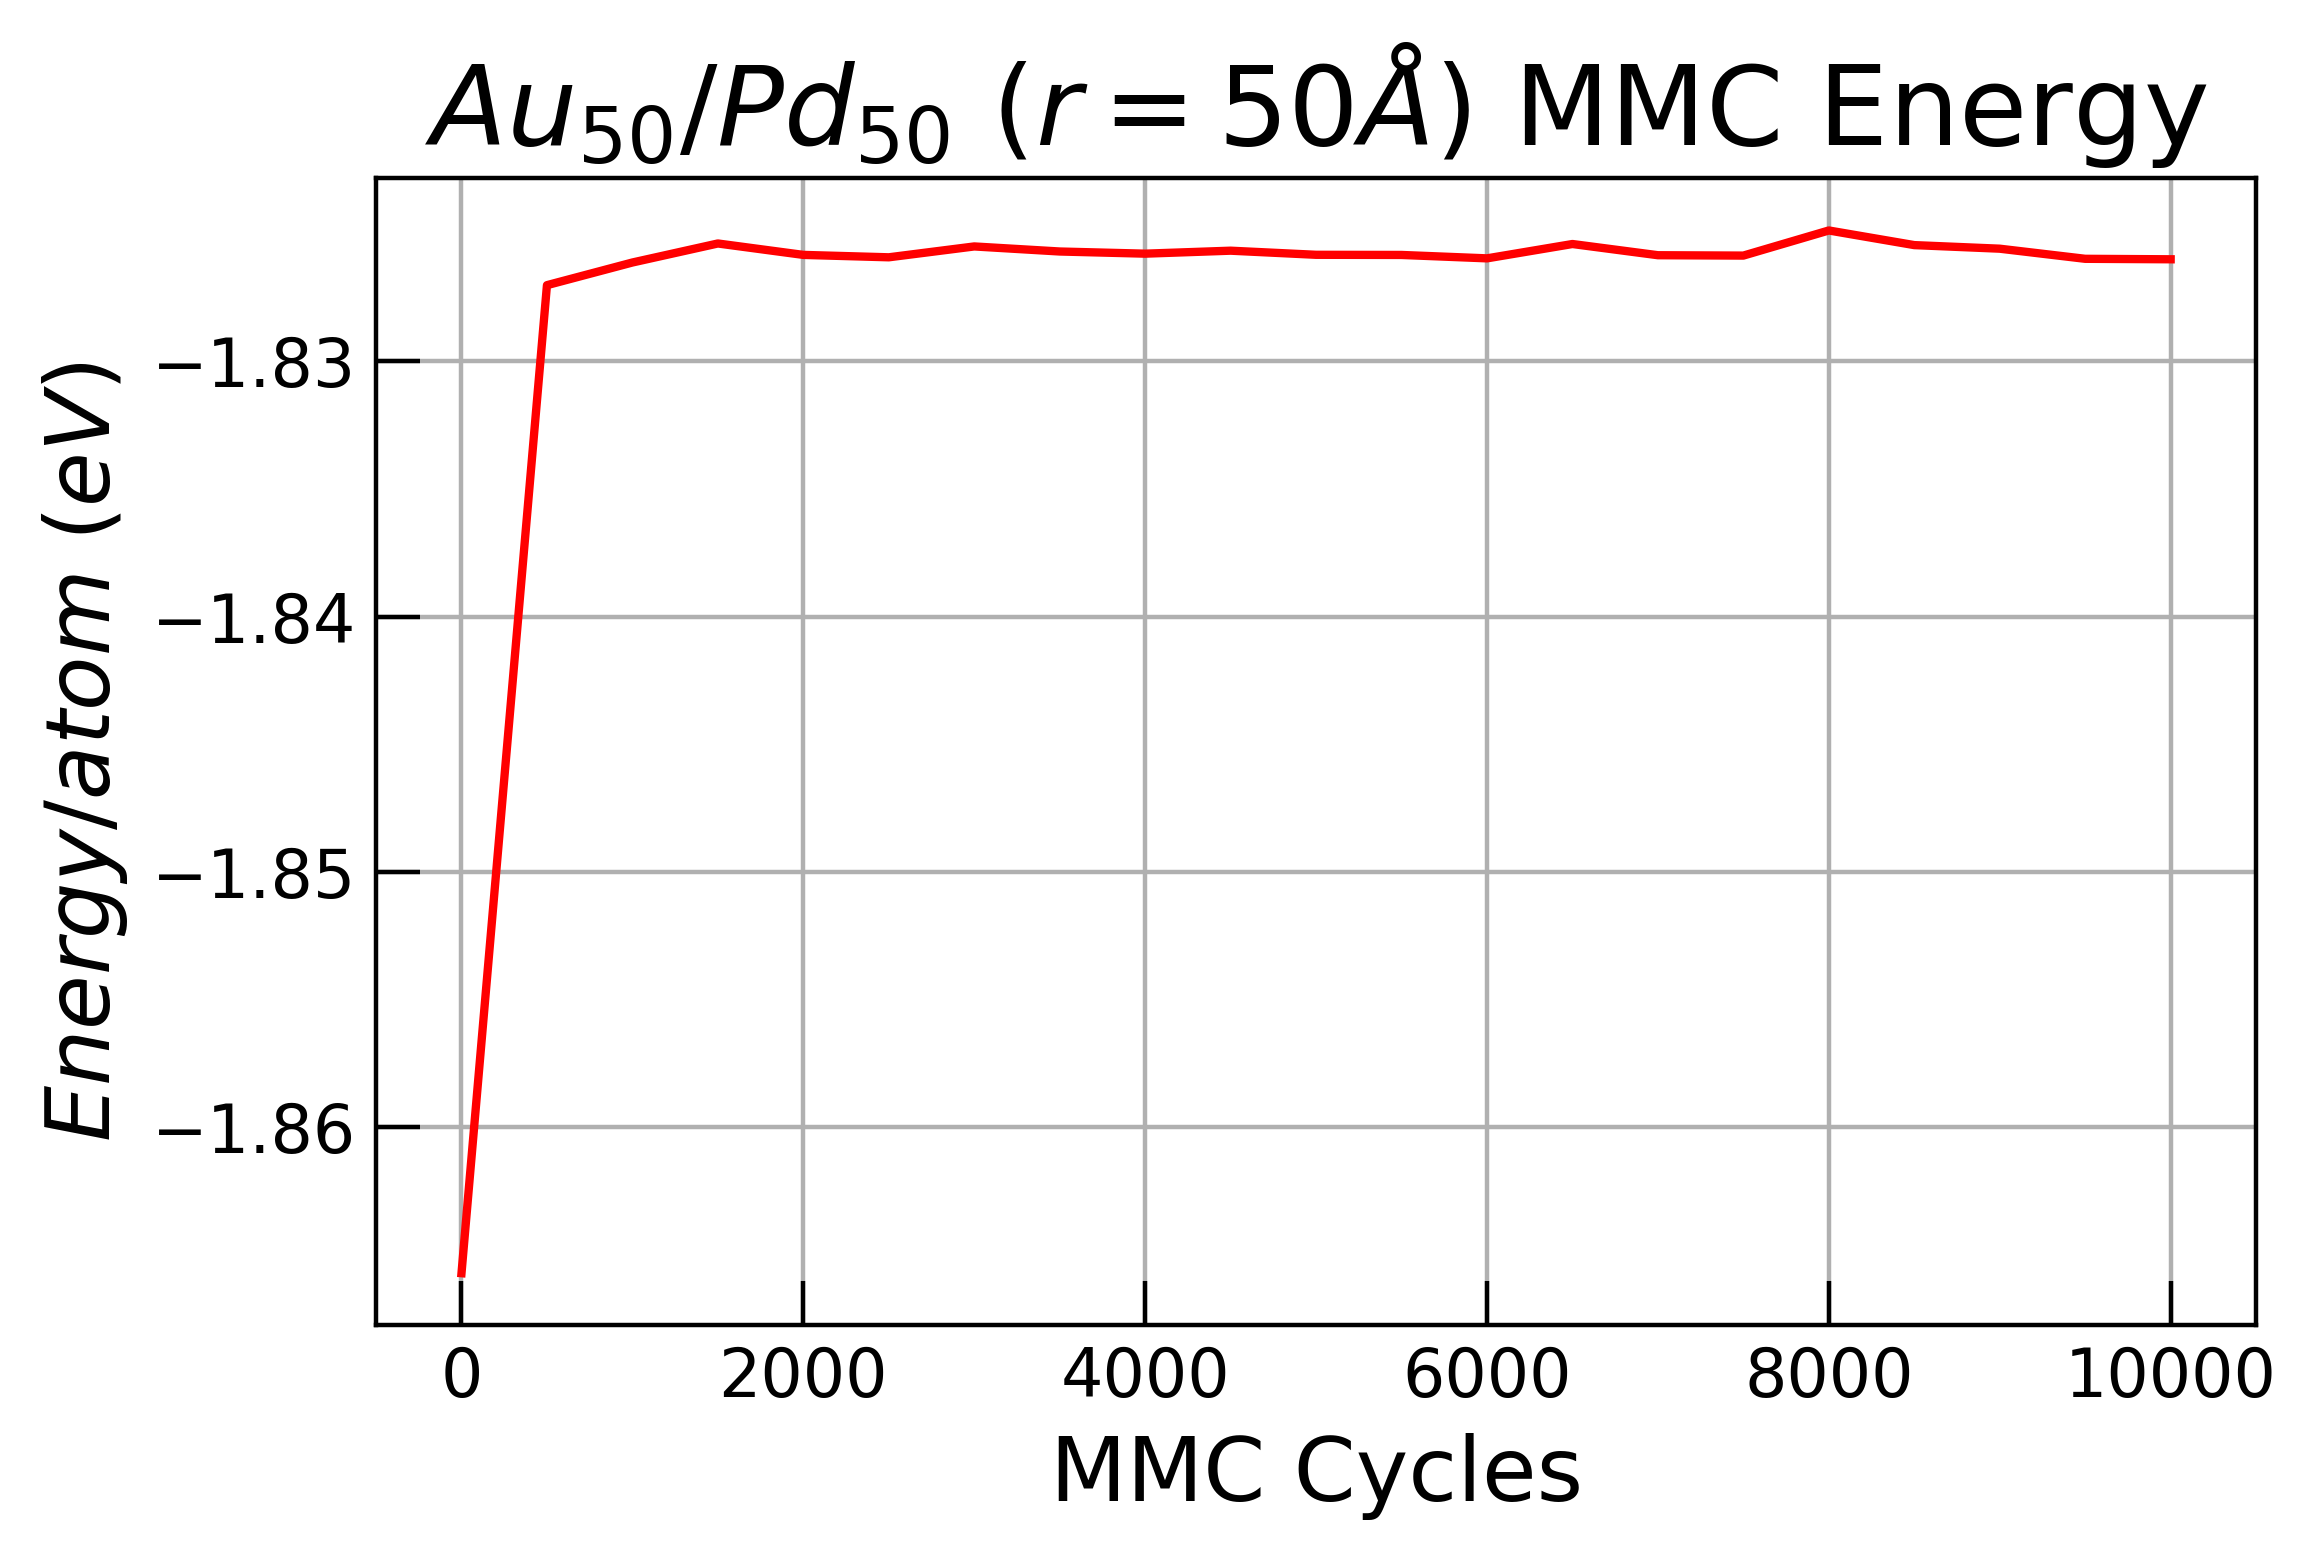

In [ ]:
fig1, ax1 = plt.subplots(figsize=(6,4,),dpi=400)
ax1.plot(np.arange(0,len(total_energy_per_cycle))*500,total_energy_per_cycle, color='red', )
# Plot settings
ax1.set_title(r'$Au_{50}/Pd_{50}$ ($r=50\AA$) MMC Energy', fontsize=20)
ax1.set_ylabel(r'$Energy/atom$ $(eV)$', fontsize=16)
ax1.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax1.set_xlabel(r'MMC Cycles', fontsize=16)
ax1.tick_params(axis='x', labelsize=12, direction='in', length=8)
#ax1.legend()
ax1.grid(True)
ax1.set_axisbelow(True)
plt.tight_layout()
#fig1.savefig(plotsavename_by_atom)
#files.download(plotsavename_by_atom)

## Energy per Atom vs Nanosphere Size (BLD interaction distance of 13 Å)

In [ ]:
# Lennard-Jones Energy of lattices as a function of the radius of the sphere
# with the BLD reaching out to 13 angstroms
sizes = [10,20,30,40,50,60,70,80,90,100]
atoms = [249,1985,6699,15711,30885,53117,84859,126341,180313,246861]
energies = [-1.3637823440784378,-1.610121350907847,-1.6956711165798894,-1.7373922221764095,-1.7635292116815366,
            -1.7832508724365899,-1.8109058637491857,-1.8105379755074056,-1.8196450789909768,
            -1.8273659727222047]
# Lennard-Jones Energy of lattices as a function of the radius of the sphere
# with the BLD reaching out to 25 angstroms
sizes25 = [100]
atoms25 = [246861]
energies25 = [-1.839502671288224]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

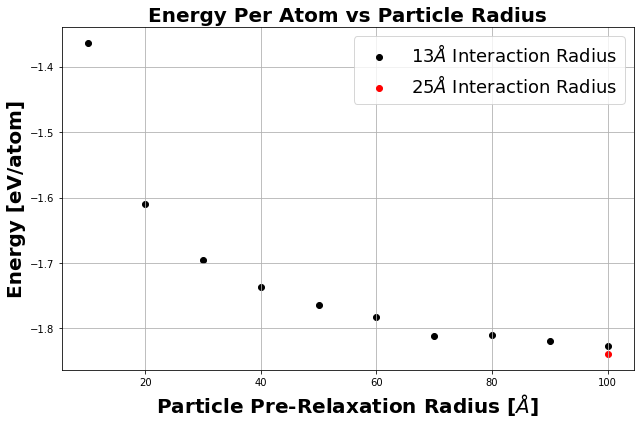

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(sizes,energies, color='black', label=r'$13\AA$'+' Interaction Radius')
ax.scatter(sizes25,energies25, color='red', label=r'$25\AA$'+' Interaction Radius')
ax.set_title(r'Energy Per Atom vs Particle Radius', fontsize=20, fontweight='bold')
ax.set_xlabel(r'Particle Pre-Relaxation Radius [$\AA$]', fontsize=20, fontweight='bold')
ax.set_ylabel(r'Energy [eV/atom]', fontsize=20, fontweight='bold')
ax.legend(fontsize=18)
ax.grid()
plt.tight_layout()
plt.savefig('EnergyPerAtom.png')
files.download('EnergyPerAtom.png')

In [ ]:
atoms = [1/(x**(1/3)) for x in atoms]
atoms25 = [1/(x**(1/3)) for x in atoms25]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

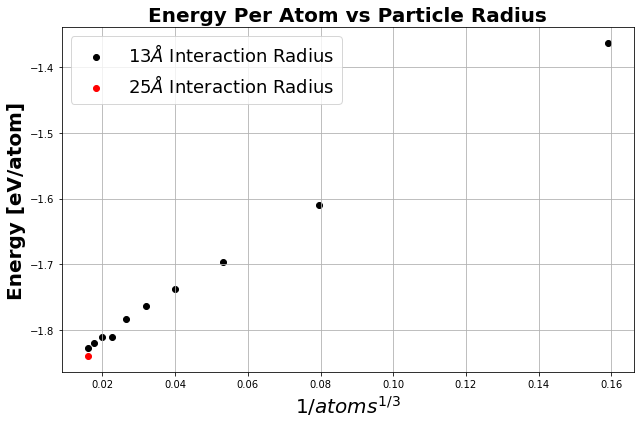

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(atoms,energies, color='black', label=r'$13\AA$'+' Interaction Radius')
ax.scatter(atoms25,energies25, color='red', label=r'$25\AA$'+' Interaction Radius')
ax.set_title(r'Energy Per Atom vs Particle Radius', fontsize=20, fontweight='bold')
ax.set_xlabel(r'$1/atoms^{1/3}$', fontsize=20, fontweight='bold')
ax.set_ylabel(r'Energy [eV/atom]', fontsize=20, fontweight='bold')
ax.legend(fontsize=18)
ax.grid()
plt.tight_layout()
plt.savefig('EnergyPerAtomv2.png')
files.download('EnergyPerAtomv2.png')

## Energy per Atom vs BLD Interaction Distance for 40Å radius sphere

In [ ]:
interaction_distance = [5,10,15,20,25]
energiesr40 = [-1.4459350055851707, -1.7208837425672021, -1.7409963963173123, -1.7448910563251787, -1.7454857044705943]
energiesr30 = [-1.4163016043906735, -1.6805702445350428, -1.698971110615917, -1.7021117499758796,-1.7027095039725435]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

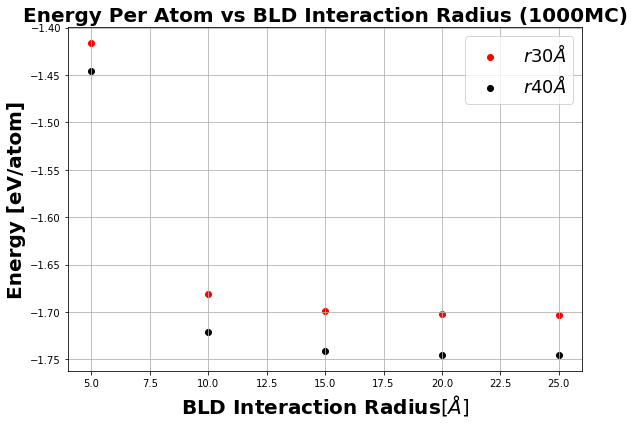

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(interaction_distance,energiesr30, color='red', label=r'$r30\AA$')
ax.scatter(interaction_distance,energiesr40, color='black', label=r'$r40\AA$')
ax.set_title(r'Energy Per Atom vs BLD Interaction Radius (1000MC)', fontsize=20, fontweight='bold')
ax.set_xlabel("BLD Interaction Radius"+r'$[\AA]$', fontsize=20, fontweight='bold')
ax.set_ylabel(r'Energy [eV/atom]', fontsize=20, fontweight='bold')
ax.legend(fontsize=18)
ax.grid()
plt.tight_layout()
plt.savefig('EnergyPerAtomVBLD.png')
files.download('EnergyPerAtomVBLD.png')

## Energy per Atom vs MMC Cycles for 25Å Au Sphere

In [ ]:
cycle_number = [0,100,200,300,400,500,600,700,
                800,900,1000,1100,1200,1300,1400,1500,
                1600,1700,1800,1900,2000]
energyperatom = [-1.7410806246238386,-1.670906815597094,-1.6657616190680984,-1.6666673722170697,-1.6649824207812463,-1.6661498479038384,-1.665365806782186,-1.6670481360856335,
                 -1.6650299773396613,-1.6640434461208424,-1.6666625417036565,-1.6659057434924511,-1.663719748770761,-1.6662222143657845,-1.6664315919205304,-1.6664336542050349,
                 -1.6654764785768412,-1.6663539755195573,-1.6646965922966304,-1.667008832001645,-1.6667010356202983]

In [ ]:
# FROM 4NN LJ
cycle_number1 = [0,100,200,300,400,500,
                 600,700,800,900,1000,
                 1100,1200,1300,1400,1500,
                 1600,1700,1800,1900,2000]
energyperatom1 = [-1.6266924290745626,-1.537382825716195,-1.53234982329232,-1.533337168301161,-1.5319578668743041,-1.5328020783709124,
                  -1.5320215671589719,-1.5336138810221893,-1.5316975124086993,-1.5311292644411316,-1.5330594690586452,
                  -1.532388537488914,-1.5306860733859573,-1.5328400263621893,-1.5331921030913265,-1.5333426285766287,
                  -1.5322134963596428,-1.533007636282992,-1.5315552358397215,-1.5335808602993282,-1.5333199014023937]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

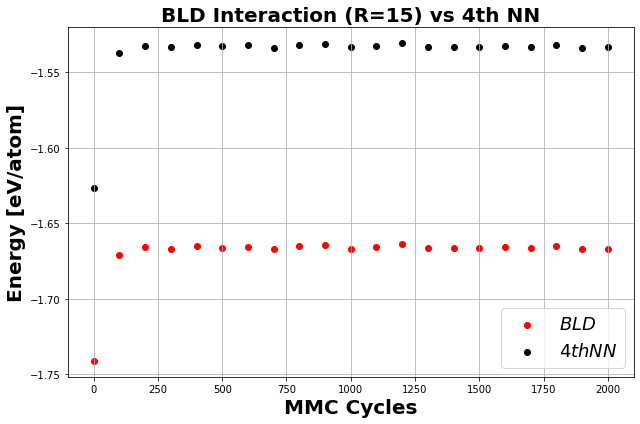

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(cycle_number1,energyperatom, color='red', label=r'$BLD$')
ax.scatter(cycle_number1,energyperatom1, color='black', label=r'$4thNN$')
ax.set_title(r'BLD Interaction (R=15) vs 4th NN', fontsize=20, fontweight='bold')
ax.set_xlabel("MMC Cycles", fontsize=20, fontweight='bold')
ax.set_ylabel(r'Energy [eV/atom]', fontsize=20, fontweight='bold')
ax.legend(fontsize=18)
ax.grid()
plt.tight_layout()
plt.savefig('EnergyPerAtomVBLD.png')
files.download('EnergyPerAtomVBLD.png')



## Lattice Paramter Evolution for FCC Au r=25Å sphere

[4.075409043355918, 4.14651078354324, 4.150433093578058, 4.149899710329872, 4.151596371848504, 4.150497109312856, 4.1509346060705905, 4.14963307307472, 4.15221564511864, 4.151521645182296, 4.1510306550009215, 4.150539787629695, 4.1510306550009215, 4.150529117963461, 4.150646487483082, 4.151084017549109, 4.1522370028542355, 4.149398462265101, 4.150710510180147, 4.150358411193703, 4.149686397626614]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

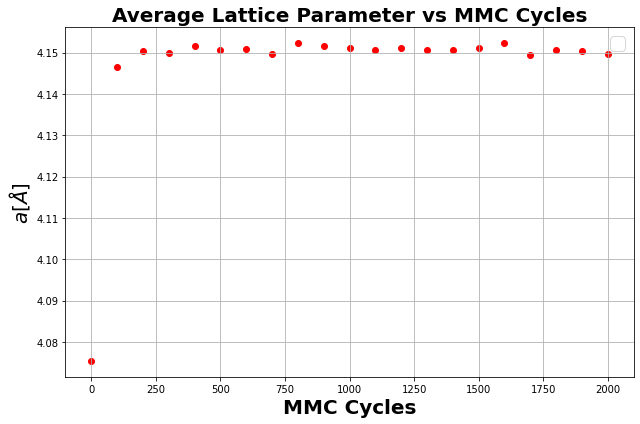

In [ ]:
# if read from the first peak of the XRD (i.e. the (111) peak)
# a = \lambda / [2*sin(\theta)] * root(3)
# \lambda is copper k alpha so \lambda = 1.5406 \AA
lam = 1.5406
cycle_number2 = [0,100,200,300,400,500,
                 600,700,800,900,1000,
                 1100,1200,1300,1400,1500,
                 1600,1700,1800,1900,2000]
thetas = [38.2194,37.5393, 37.5025, 37.5075, 37.4916, 37.5019,
          37.4978, 37.5100, 37.4858, 37.4923, 37.4969,
          37.5015, 37.4969, 37.5016, 37.5005, 37.4964,
          37.4856, 37.5122, 37.4999, 37.5032, 37.5095]

a = [ np.sqrt(3)*lam / (2*np.sin( x/2 * np.pi/180)) for x in thetas]



fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(cycle_number2,a, color='red')
ax.set_title(r'Average Lattice Parameter vs MMC Cycles', fontsize=20, fontweight='bold')
ax.set_xlabel("MMC Cycles", fontsize=20, fontweight='bold')
ax.set_ylabel(r'$a [\AA]$', fontsize=20, fontweight='bold')
ax.legend(fontsize=18)
ax.grid()
plt.tight_layout()
plt.savefig('LatticeParameterEvolution.png')
files.download('LatticeParameterEvolution.png')